In [1]:
!pip install sentence_transformers

                                              0.0/86.0 kB ? eta -:--:--
     -----------------------                  51.2/86.0 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/7.1 MB ? eta -:--:--
     --                                       0.5/7.1 MB 15.2 MB/s eta 0:00:01
     ---------                                1.8/7.1 MB 22.3 MB/s eta 0:00:01
     ------------------                       3.4/7.1 MB 26.8 MB/s eta 0:00:01
     ---------------------------              4.9/7.1 MB 28.6 MB/s eta 0:00:01
     ----------------------------------       6.1/7.1 MB 32.3 MB/s eta 0:00:01
     ---------------------------------------- 7.1/7.1 MB 26.6 MB/s eta 0:00:00
                                              0.0/172.3 MB ? eta -:--:--
                                              0.

In [20]:

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')
     

In [21]:

sentences = [
    "it caught him off guard that space smelled of seared steak",
    "she could not decide between painting her teeth or brushing her nails",
    "he thought there'd be sufficient time is he hid his watch",
    "the bees decided to have a mutiny against their queen",
    "the sign said there was road work ahead so she decided to speed up",
    "on a scale of one to ten, what's your favorite flavor of color?",
    "flying stinging insects rebelled in opposition to the matriarch"
]
     

In [22]:
# uses the model, and then creates numeric vectors for the sentences above
embeddings = model.encode(sentences)
embeddings.shape

(7, 768)

In [23]:
embeddings

array([[ 0.07613572,  0.03554152, -0.04853425, ...,  0.02156137,
        -0.02294153, -0.01750991],
       [ 0.0234846 ,  0.03777696, -0.02441059, ..., -0.00101799,
         0.01494203, -0.00690052],
       [-0.01087208, -0.06204988, -0.02355076, ...,  0.04565978,
         0.00899552, -0.0435399 ],
       ...,
       [-0.00952112, -0.00817685, -0.0054946 , ..., -0.01066917,
         0.00550097, -0.01924827],
       [-0.0031365 ,  0.03131974, -0.00896536, ...,  0.04947063,
        -0.04866311, -0.003522  ],
       [ 0.00355428, -0.04229821,  0.01761915, ...,  0.01523385,
         0.01262348, -0.01886441]], dtype=float32)

Cosine similarity is able to identify sentences that mean the same thing. 
To check score for different sentences, need to change the cos_sim index pointers

In [29]:
from sentence_transformers.util import cos_sim

scores = cos_sim(embeddings[0], embeddings[1:])

print(sentences[0])
for i, score in enumerate(scores[0]):
    print(f"{round(score.item(), 4)} | {sentences[i]}")

it caught him off guard that space smelled of seared steak
0.1293 | it caught him off guard that space smelled of seared steak
0.3083 | she could not decide between painting her teeth or brushing her nails
0.1389 | he thought there'd be sufficient time is he hid his watch
0.1416 | the bees decided to have a mutiny against their queen
0.097 | the sign said there was road work ahead so she decided to speed up
0.1232 | on a scale of one to ten, what's your favorite flavor of color?


## Question Answer

In [40]:
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer, DPRQuestionEncoder, DPRQuestionEncoderTokenizer
ctx_model = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

question_model = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [45]:
questions = [
    "what is the capital city of australia?",
    "what is the best selling sci-fi book?",
    "how many searches are performed on Google?",
    "How many students study in Canada each year?"
]

contexts = [
    "canberra is the capital city of australia",
    "the capital city of france is paris",
    "sc-fi is a popular book genre read by millions",
    "the best-selling sci-fi book is dune",
    "Google serves more than 2 trillion queries annually",
    "Google is a popular search engine"
]

In [46]:
xb_tokens = ctx_tokenizer(contexts, max_length=256, padding='max_length',
                          truncation=True, return_tensors='pt')
xb = ctx_model(**xb_tokens)

xq_tokens = question_tokenizer(questions, max_length=256, padding='max_length',
                               truncation=True, return_tensors='pt')
xq = question_model(**xq_tokens)

In [47]:
xb.pooler_output.shape, xq.pooler_output.shape

(torch.Size([6, 768]), torch.Size([4, 768]))

In [48]:
import torch

for i, xq_vec in enumerate(xq.pooler_output):
    probs = cos_sim(xq_vec, xb.pooler_output)
    argmax = torch.argmax(probs)
    print(questions[i])
    print(contexts[argmax])
    print('---')

what is the capital city of australia?
canberra is the capital city of australia
---
what is the best selling sci-fi book?
the best-selling sci-fi book is dune
---
how many searches are performed on Google?
Google serves more than 2 trillion queries annually
---
How many students study in Canada each year?
sc-fi is a popular book genre read by millions
---


## Image-Text Embedding

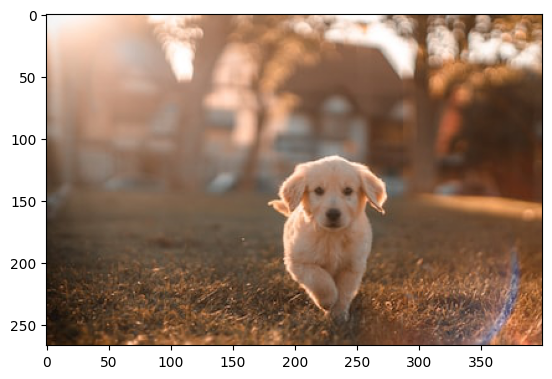

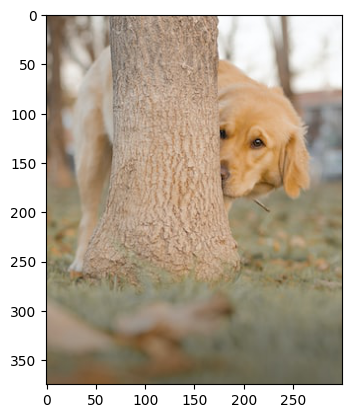

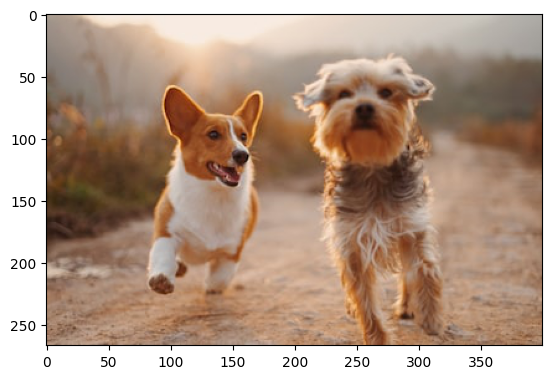

In [35]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import requests

urls = [
    "https://images.unsplash.com/photo-1576201836106-db1758fd1c97?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=400&q=80",
    "https://images.unsplash.com/photo-1591294100785-81d39c061468?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=300&q=80",
    "https://images.unsplash.com/photo-1548199973-03cce0bbc87b?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=400&q=80"
]

images = [
    Image.open(requests.get(url, stream=True).raw) for url in urls]

# let's see what we have
for image in images:
    plt.show(plt.imshow(np.asarray(image)))

In [36]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

In [37]:
 captions = ["a dog hiding behind a tree",
            "two dogs running",
            "a dog running",
            "a cucumber on a tree",
            "trees in the park",
            "a cucumber dog"]

inputs = processor(
    text=captions, images=images,
    return_tensors='pt', padding=True
)

outputs = model(**inputs)

probs = outputs.logits_per_image.argmax(dim=1)
probs

tensor([2, 0, 1])

a dog running


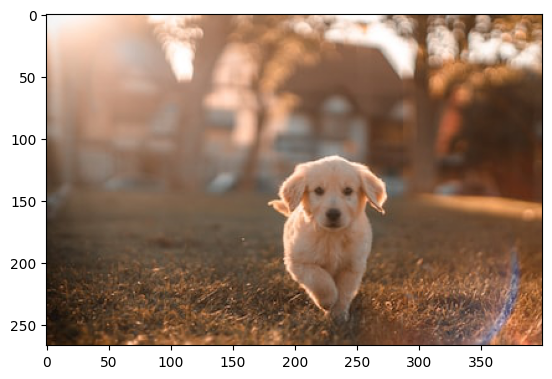

a dog hiding behind a tree


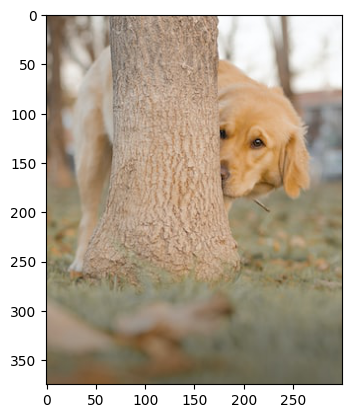

two dogs running


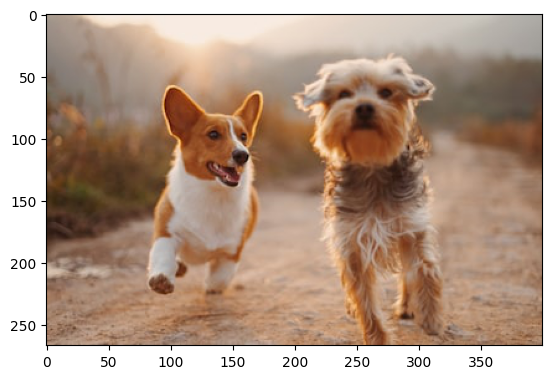

In [38]:
for i, image in enumerate(images):
    argmax = probs[i].item()
    print(captions[argmax])
    plt.show(plt.imshow(np.asarray(image)))

In [39]:

# requirements:
! pip install huggingface_hub accelerate
! git config --global credential.helper store

                                              0.0/219.1 kB ? eta -:--:--
     --------------------------             153.6/219.1 kB 4.6 MB/s eta 0:00:01
     -------------------------------------- 219.1/219.1 kB 4.4 MB/s eta 0:00:00


## Cosine Similarity

In [1]:
import numpy as np

def calculate_cosine_similarity(sentence1, sentence2):
    # Create a set of unique words from both sentences
    word_set = set(sentence1.split() + sentence2.split())

    # Create vectors representing the frequency of each word in each sentence
    vector1 = np.array([sentence1.split().count(word) for word in word_set])
    vector2 = np.array([sentence2.split().count(word) for word in word_set])

    # Calculate the dot product of the two vectors
    dot_product = np.dot(vector1, vector2)

    # Calculate the magnitude of each vector
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the cosine similarity
    cosine_similarity = dot_product / (magnitude1 * magnitude2)

    return cosine_similarity

# Test the function
sentence1 = "The cat chased the mouse."
sentence2 = "The cat chased the mouse in the garden."
sentence3 = "The cat chased the elephant in the garden."

similarity_score = calculate_cosine_similarity(sentence1, sentence2)
print(f"The cosine similarity between the two sentences is: {similarity_score}")

The cosine similarity between the two sentences is: 0.7071067811865475


In [2]:
similarity_score = calculate_cosine_similarity(sentence1, sentence3)
print(f"The cosine similarity between the two sentences is: {similarity_score}")

The cosine similarity between the two sentences is: 0.7071067811865475


## Hugging Face APIs

Let’s look into how Hugging Face APIs can help generate text using LLMs like Bloom, Roberta-base, etc. First, we need to sign up for Hugging Face and copy the token for API access. After signup, hover over to the profile icon on the top right, click on settings, and then Access Tokens.

#### Example 1: Sentence Completion

Let’s look at how we can use Bloom for sentence completion. The code below uses the hugging face token for API to send an API call with the input text and appropriate parameters for getting the best response.

In [5]:
from huggingface_hub import notebook_login
from huggingface_hub import HfFolder


#enter your API key, you can make one for free on HF
notebook_login()

ImportError: The `notebook_login` function can only be used in a notebook (Jupyter or Colab) and you need the `ipywidgets` module: `pip install ipywidgets`.

In [ ]:
from huggingface_hub import InferenceApi
inference = InferenceApi("bigscience/bloom",token=HfFolder.get_token())